# Import

In [ ]:
# https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93
# https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272

Trained using colab

In [ ]:
!pip install transformers
!pip install pyphen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelWithLMHead

import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

import os
import gc

import re

import pyphen

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Testing syllab splitter

In [ ]:
dic = pyphen.Pyphen(lang='pl')
print(dic.inserted('miłość').strip().split('-')[-1])
print(dic.inserted('pniak'))
print(dic.inserted('parkan'))

łość
pniak
par-kan


# Get data
## Poetry


In [ ]:
poetry_list  = os.listdir('drive/MyDrive/poems/poetry2') 

poetry_df_list = []
for i, p in enumerate(poetry_list):
    ### Prepare data
    df_tmp = pd.read_csv(f'drive/MyDrive/poems/poetry2/{p}', sep=';')
    df_tmp['author'] = p.split('.')[0]
    poetry_df_list.append(df_tmp)

#     df = df[df['poem'].apply(lambda x: len(x.split(' ')) < 350)]

poetry_selected = pd.concat(poetry_df_list)

print(poetry_selected.shape)

poetry_selected.head()

(969, 3)


,title,poem,author
0,(Fraszki dodane) Na Leliwę Tarnowskich,"Nastań szczęśliwie ty, Miesiącu nowy,\nZ taką ...",kochanowski_jan
1,(Fraszki dodane) Na słownik Mączyńskiego,"Żebyś do szkoły nie po wszytko chodził,\nAle s...",kochanowski_jan
2,(Fraszki dodane) Nagrobek Stanisławowi Grzepsk...,"To miejsce, w którym ciało twoje pochowano,\nG...",kochanowski_jan
3,(Fraszki dodane) Pełna prze zdrowie,"Prze zdrowie gospodarz pije,\nWstawaj, gościu!...",kochanowski_jan
4,(Fraszki dodane) Przymówka chłopska,"„Pijże, włodarzu!” — „Panie, jużem podpił sobi...",kochanowski_jan


In [ ]:
def detect_rhymes(text):
    syllabes = {}
    for t in text.split('\n'):
        s = dic.inserted(t).strip().split('-')[-1]
        if s in syllabes:
            syllabes[s] = syllabes[s] + 1
        else:
            syllabes[s] = 1
    return list(syllabes.values())

In [ ]:
poetry_selected = poetry_selected.dropna()

In [ ]:
poetry_selected['rhymes'] = poetry_selected['poem'].apply(detect_rhymes)

In [ ]:
poetry_selected = poetry_selected[poetry_selected['rhymes'].apply( lambda x: np.max(x)) > 1]

## Sonety

In [ ]:
sonets_list = os.listdir('drive/MyDrive/poems/sonety') 

sonety_str = ''
for i, s in enumerate(sonets_list):
    ### Prepare data
    with open(f'drive/MyDrive/poems/sonety/{s}', 'r') as f:
        sonety_str = sonety_str + f.read().replace('\u2009', ' ') + '\n\n\n\n\n\n'

#     df = df[df['poem'].apply(lambda x: len(x.split(' ')) < 350)]

sonety = []
for s in sonety_str.split('\n\n\n\n\n'):
    if len(s) > 0:
        s_clean = s.strip('\n').strip() 
        if '\n\n\n\n' in s_clean:
            s_clean = s_clean.replace('\n\n', '\n').replace('\n\n', '\n')
        s_clean = s_clean.replace('\n ', '\n').replace('\n', ' ').replace('...', '.')
        s_clean = re.sub('\[[0-9]+\]', '', s_clean)
        s_clean = re.sub('[,;\(\)]', '', s_clean)
        sonety.append(s_clean)
len(sonety)

24

## Pan Tadeusz

In [ ]:
with open(f'drive/MyDrive/poems/pantadeusz/pantadeusz.txt', 'r') as f:
    pan_str = f.read()

pantadeusz = []
for p in pan_str.split('\n\n'):
    if len(p.split('\n')) > 3:        
        pantadeusz.append(p.strip())
len(pantadeusz)

743

In [ ]:
poetry_to_use = poetry_selected[poetry_selected['poem'].notna()][['poem']]
poetry_to_use = poetry_to_use[(poetry_to_use['poem'].apply(lambda x: len(x.strip().split(' ')) ) < 200)]
poetry_to_use = poetry_to_use['poem'].apply(lambda x: x.strip().split('\n\n\n')[0] ).values

poetry_to_use.shape

(672,)

In [ ]:
# poetry_to_use = pantadeusz
# len(poetry_to_use)

# Preparation
## Tokenizer

In [ ]:
# #Get the tokenizer and model
# tokenizer = GPT2Tokenizer.from_pretrained('flax-community/papuGaPT2',
#                                           bos_token='<|startoftext|>', 
#                                           eos_token='<|endoftext|>', 
#                                           pad_token='<|pad|>')

tokenizer = AutoTokenizer.from_pretrained('flax-community/papuGaPT2',
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>',
                                          sep_token='<|sep|>')

# model = AutoModelWithLMHead.from_pretrained('flax-community/papuGaPT2')

# #Accumulated batch size (since GPT2 is so big)
# def pack_tensor(new_tensor, packed_tensor, max_seq_len):
#     if packed_tensor is None:
#         return new_tensor, True, None
#     if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
#         return packed_tensor, False, new_tensor
#     else:
#         packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
#         return packed_tensor, True, None

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
max_flavour = max([len(tokenizer.encode(s)) for s in poetry_to_use])

print(f'The longest flavour text is {max_flavour} tokens long.')

The longest flavour text is 606 tokens long.


## Dataset

In [ ]:
class Poems(Dataset):  
    def __init__(self, txt_list, tokenizer, max_length=max_flavour):
        super().__init__()

        self.tokenizer = tokenizer
        self.poems = []
        self.attn_masks = []

        for s in tqdm(txt_list):
            encodings_dict = tokenizer('<|startoftext|>'+ 
                                       s#.replace('\n', '<|sep|>') 
                                       + '<|endoftext|>', 
                                    truncation=True, 
                                    max_length=max_length, 
                                    padding="max_length")
                        
            self.poems.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            
        self.poems_count = len(self.poems)
        
    def __len__(self):
        return self.poems_count

    def __getitem__(self, idx):
        return self.poems[idx], self.attn_masks[idx] 


In [ ]:
from torch.utils.data import random_split

dataset = Poems(poetry_to_use, tokenizer, max_length=max_flavour)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

100%|██████████| 672/672 [00:00<00:00, 1703.20it/s]


'There are 604 samples for training, and 68 samples for validation testing'

## DataLoader

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

bs=4

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

## Model

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('flax-community/papuGaPT2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = AutoModelWithLMHead.from_pretrained("flax-community/papuGaPT2", config=configuration)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


## Verify model

In [ ]:
prompt = "Litwo Ojczyzno moja ty jesteś jak zdrowie\n"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

sample_outputs = model.generate(
    generated,
    do_sample=True, 
    max_length=100, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=1
)


for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Litwo Ojczyzno moja ty jesteś jak zdrowie
nasze dzieci, które tak jak nasi rodzice, tak i my dorośli, zawsze się staramy być, aby nasze dzieci były szczęśliwe, aby my byli szczęśliwi, aby my byli szczęśliwi, aby my żyli i my szczęśliwi.
Z okazji 100. rocznicy odzyskania przez Polskę niepodległości zapraszamy uczniów i nauczycieli do wspólnego zaśpiewania hymnu narodowego. Przed publicznością wystąpi Zespół Młodzieżowej Orkiestry Dętej „Freedom”.
Zespół został założony przez uczniów klas 4-7 oraz




In [ ]:
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Training preparation

In [ ]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 5
warmup_steps = 1e2
sample_every = 100

In [ ]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

# Train

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

prev_val_loss = np.inf

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0
    total_train_perplexity = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            # for i, sample_output in enumerate(sample_outputs):
            #       print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)      

    total_train_perplexity = np.exp(avg_train_loss)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_perplexity = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    total_eval_perplexity = np.exp(avg_val_loss)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Perplexity': total_train_perplexity,
            'Valid. Loss': avg_val_loss, 
            'Valid. Perplexity': total_eval_perplexity,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    if prev_val_loss < avg_val_loss: 
        print('Prev validation loss', prev_val_loss)
        print('Current validation loss', avg_val_loss)
        break

    prev_val_loss = avg_val_loss

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 151. Loss:2.2973923683166504. Time:0:01:09
Average Training Loss: 4.686531042026369. Epoch time: 0:01:46
Validation loss: 1.4456130792112911. Validation Time: 0:00:04
Beginning epoch 2 of 5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 151. Loss:1.5086257457733154. Time:0:01:11
Average Training Loss: 1.286934925625656. Epoch time: 0:01:48
Validation loss: 1.383051707464106. Validation Time: 0:00:04
Beginning epoch 3 of 5


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 151. Loss:1.1593855619430542. Time:0:01:12
Average Training Loss: 1.093914453754362. Epoch time: 0:01:50
Validation loss: 1.3998002409934998. Validation Time: 0:00:04
Prev validation loss 1.383051707464106
Current validation loss 1.3998002409934998
Total training took 0:05:37


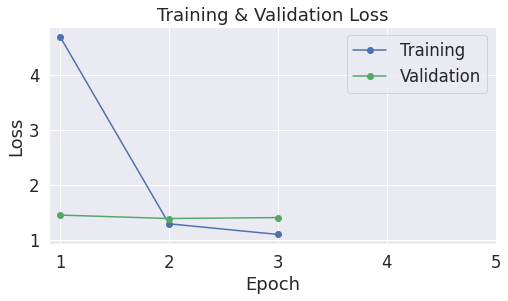

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,4)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

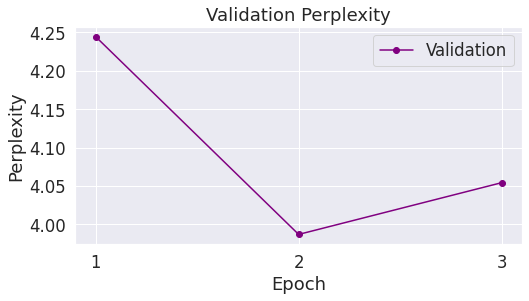

In [ ]:
# Plot the learning curve.
# plt.plot(df_stats['Training Perplexity'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Perplexity'], color='purple', marker='o', label="Validation")

# Label the plot.
plt.title("Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# Validate model

In [ ]:
model.eval()

prompt = "<|startoftext|>"
#prompt = "Litwo Ojczyzno moja ty jesteś jak zdrowie\n"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 200,
                                top_p=0.95, 
                                num_return_sequences=1
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True).replace('<|sep|>', '\n')))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RuntimeError: ignored

# Save model

In [ ]:
model_g = model.to('cpu')

In [ ]:
model_g.save_pretrained("drive/MyDrive/poems/papuga-poetry-rhymes-only")